
### What is the impact of schema restricted outputs on determinism and performance?

Contact: Breck Baldwin, breck_baldwin@gmail.com

Location of this notebook: 
https://github.com/breckbaldwin/llm-stability/blob/main/experiments/json_schema/analysis.ipynb

Suggested background band: Viagr aBoys

We have shown (https://arxiv.org/pdf/2408.04667) that non-determinism is very prevelant even with what are assumed to be maximilly deterministic settings, e.g., temperature=0.0 and top p/k=1.0.

Assuming that determinism is desirable, which is the case in many engineering use cases, a natural follow-on effort is to see if determinism can be achieved via methods outside of the available parameters. Schemas are also desirable for specifying interfaces between LLMs and other software components, e.g, a database that needs a particular format or API. 

This notebook addresses the impact of specifying a JSON schema in the prompt and request that it be adhered to.

We will measure degree of determinism as well as any impact on accuracy. 

TL;DR Schemas do help with determinism generally at the raw output level and answer level but it may come with a performance penalty on accuracy. More models/tasks should be evaluated. 

####  Asking nicely: Specify JSON schema and request its use

Below is a JSON schema query following suggested best practices that I don't recall the source of, particularly the bit about giving positive and negative examples in the prompt. Apologies to the source, reach out and I'll update. The below prompt for A-D multiple choice question:

```
json_schema_prompt = """
Please answer the following question adhering to these format instructions:
The output should be formatted as a JSON instance that conforms to the JSON schema below.
 
{
  "$schema": "http://json-schema.org/draft-04/schema#",
  "type": "object",
  "properties": {
    "Answer": {
      "type": "string",
      "enum" : ["A", "B", "C", "D"]
    }
  },
  "required": [
    "Answer"
  ]
}

The output {"Answer": "A"} is a well-formatted instance of the schema, the output {"Answer": "E"} is not well-formatted. A string answer like "The correct answer is A" is not well-formatted.

The question is: 
"""
```
The schema case prepends the above to few-shot questions. A few-shot question gives the LLM a few examples to help it understand the task and they performed better--this is from the ruin_names task.

```
"""
Which of the following is a humorous edit of this artist or movie name: 'whitesnake'?
Options:
(A) whitesnape
(B) whitesnapke
(C) whitesnuake
(D) mwhitesnake A:Let's think step by step.
The original name is "whitesnake". This is the name of an old English hard rock band. It is a compound word, formed by the words "white" and "snake".
(A) "whitesnape": It is formed by the combination of "white" and "snake"; therefore, "snake" has been changed to "snape". Snape makes a reference to the fictional character Severus Snape in the Harry Potter series, so (A) is indeed a meaningful and funny edit.
(B) "whitesnapke": It is formed by the combination of "white" and "snapke", but "snapke" is not an actual word; therefore, "whitesnapke" is not humorous.
(C) "whitesnuake": It is formed by the combination of "white" and "snuake", but "snuake" is not an actual word; therefore, "whitesnuake" is not humorous.
(D) "mwhitesnake": It is formed by the combination of "m", "white", and "snake", but the prefix "-m "seems arbitrary; therefore, "mwhitesnake" is not meaningful or humorous.
Above the above, the only humorous edit is (A). So the answer is (A).
Which of the following is a humorous edit of this artist or movie name: 'one of our dinosaurs is missing'?
Options:
(A) ofne of our dinosaurs is missing
(B) one af our dinosaurs is missing
(C) one of our dinosaurs is pissing
(D) one of our dinosaur is missing A:Let's think step by step.
The original name is "one of our dinosaurs is missing". This is the name of an old British movie.
(A) "ofne of our dinosaurs is missing": Here "one of" is changed to "ofne", but the word "ofne" is not an actual word.
(B) "one af our dinosaurs is missing": Here the word "of" is changed to "af", but the word "af" is not an actual word.
(C) "one of our dinosaurs is pissing": Here the word "missing" is changed to "pissing", and "one of our dinosaurs is pissing" is indeed a very whimsical and mischievous edit. This change truly ruins the original title of the movie.
(D) "one of our dinosaur is missing": Here the word "dinosaurs" is changed to "dinosaur", but "dinosaur" is singular but should be plural in the title; this change therefore feels arbitrary and not humorous.
Above the above, the only humorous edit is (C).
Above the above, the only humorous edit is (C). So the answer is (C).
Which of the following is a humorous edit of this artist or movie name: 'counting crows'?
Options:
(A) countingy crows
(B) counting cows
(C) courting crows
(D) coutnting crows A:Let's think step by step.
The original name is "counting crows". This is the name of an American rock band. Historically, the band name comes from the British nursery rhyme "One for Sorrow", which is about counting of magpies.
(A) "countingy crows": Here the word "counting" is changed to "countingy", but the word "countingy" is not an actual word.
(B) "counting cows": Here the word "crows" is changed to "cows", and this is indeed a playful and meaningful edit that ruins the original name of the band.
(C) "courting crows": Here the word "counting" is changed to "courting", and "courting" is an actual word; however, "courting crows" does not sound as humorous as "counting cows".
(D) "coutnting crows": Here the word "counting" is changed to "coutnting", but the word "coutnting" is not an actual word.
Above the above, the only humorous edit is (B). So the answer is (B). Which of the following is a humorous edit of this artist or movie name: 'rain man'?
Options:
(A) ruin man
(B) rains man
(C) rain men
(D) rainmman
"""

```

So the answer should be chosen from 'ruin man', 'rains man' etc...

Code to run evaluation is in `python run_schema.py`, prompts for A-K and Yes-No are in that code. 

The `non-schema` runs being used for comparison come from `experiments/v2/runs` with the first 5 runs being copied over to the local `runs` directory. The `schema` runs came from `python run_schema.py`. Then the standard `python ../../evaluate.py -d runs` was executed on the uncompressed `runs.tgz`. 


The game here is to compare levels of determinism and answer performance between a regular prompt, named "non-schema" and a schema restricted prompt, named "schema". 

In [22]:
import pandas as pd
from itertools import product
from collections import defaultdict

stability_df = pd.read_csv('stability_eval.csv')
# schema runs will have 'JSON schema' in the model_config column
stability_df['schema_config'] = \
        stability_df['model_config'].apply(lambda x: 'schema' 
                                           if 'JSON schema' in x else 'non-schema')
for col in ['TARr', 'TARa', 'best_possible_accuracy', 
               'worst_possible_accuracy']:
   stability_df[f'{col} value'] = stability_df[col].str.strip('%').astype(float)/100
stability_df['model_task'] = stability_df['model'] + ' ' + stability_df['task']


#display(stability_df)

# TARr

Lets start by graphing the TARr numbers--our most uptight metric for system determinism. The definition is:

TARr (total agreement rate raw): The count of string equivalent question answers that match on all N runs over the number of rubrics/questions.

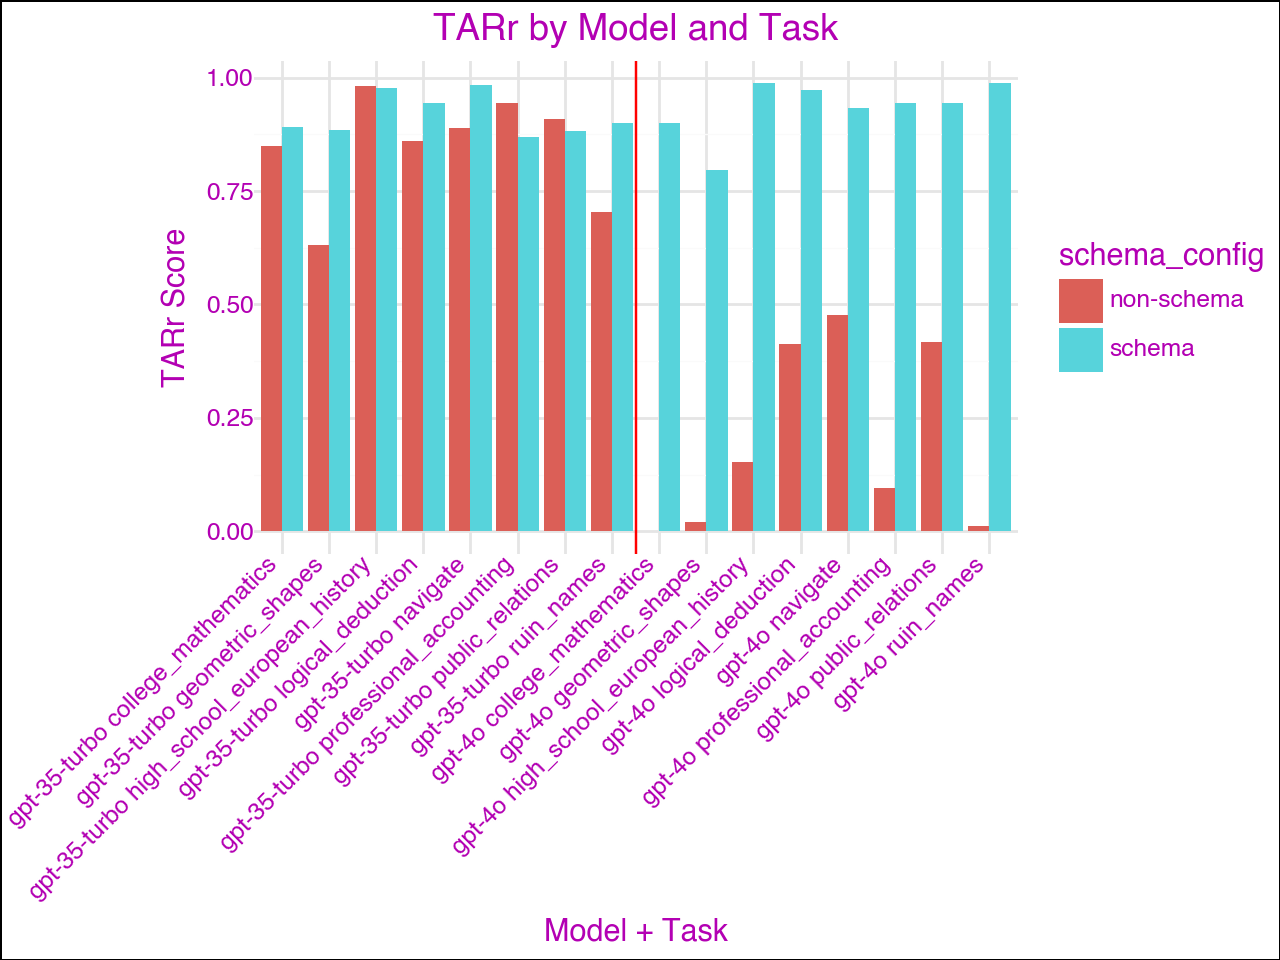

In [ ]:
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs, theme, element_text, position_dodge, element_rect, geom_vline

def plot_metrics(stability_df, metric='TARr', color="#b300b3"):

    return (ggplot(stability_df, aes(x='model_task', y=f'{metric} value', fill='schema_config'))
    + geom_bar(stat='identity', position=position_dodge(width=0.9))
    + geom_vline(xintercept=8.5, color='red', linetype='solid')
    + theme_minimal()
    + labs(title=f'{metric} by Model and Task',
            x='Model + Task',
            y=f'{metric} Score')
    + theme(axis_text_x=element_text(angle=45, hjust=1),
            text=element_text(color=color),
            axis_text=element_text(color=color),
            plot_background=element_rect(fill='none'),
            panel_background=element_rect(fill='none')))
    
    
display(plot_metrics(stability_df, 'TARr', color="#b300b3"))

GPT-3.5 already does pretty well on TARr but the schema helps for 6 out of 8 tasks. GPT-4o does very poorly on non-schema TARr but introduciton of a schema makes a huge difference. If stability matters then schemas generally help, sometimes a lot.

Next up we look at TARa:

TARr (total agreement rate answer): The count of answer equivalent question that match on all N runs over the number of rubrics/questions. Answer equivalent means 'The answer is (A)' is the same as '(A) is the answer'.

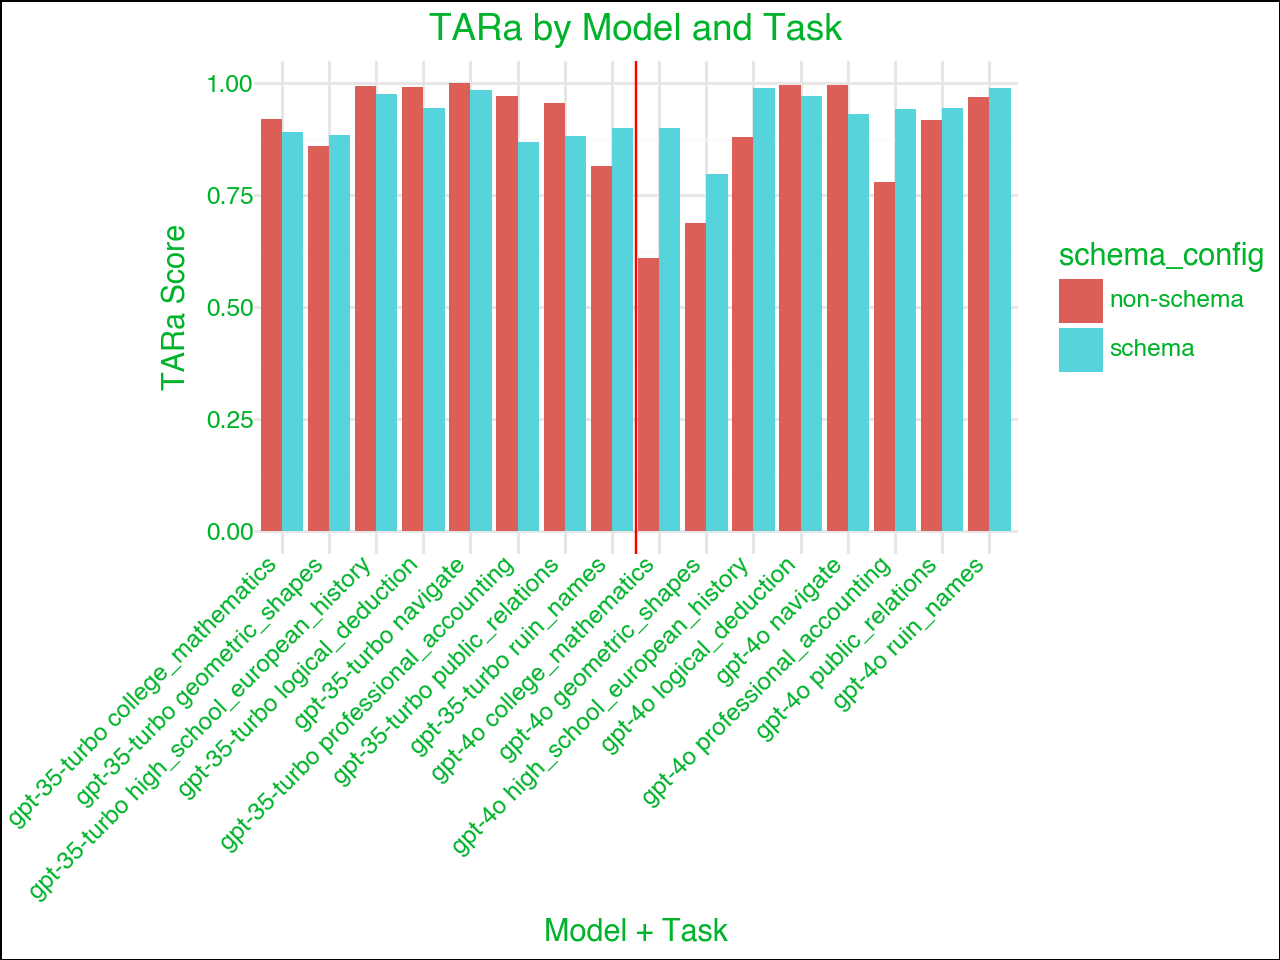

In [ ]:

display(plot_metrics(stability_df, 'TARa', color="#00b32a"))

The abstracting afforded by the answer parsing reveals much better consistency--no surprise. However there is a trend for GPT-3.5 where the schema slightly hurts answer consistency 6 out of 8 tasks and for GPT-4o it hurts for 7 out of 8 tasks. But neither effect is large. 

How about answer accuracy? 

Starting with best_possible_accuracy:

Best possible accuracy: This is a maximally optimistic metric that says if any of the runs got the answer right then score it right. 

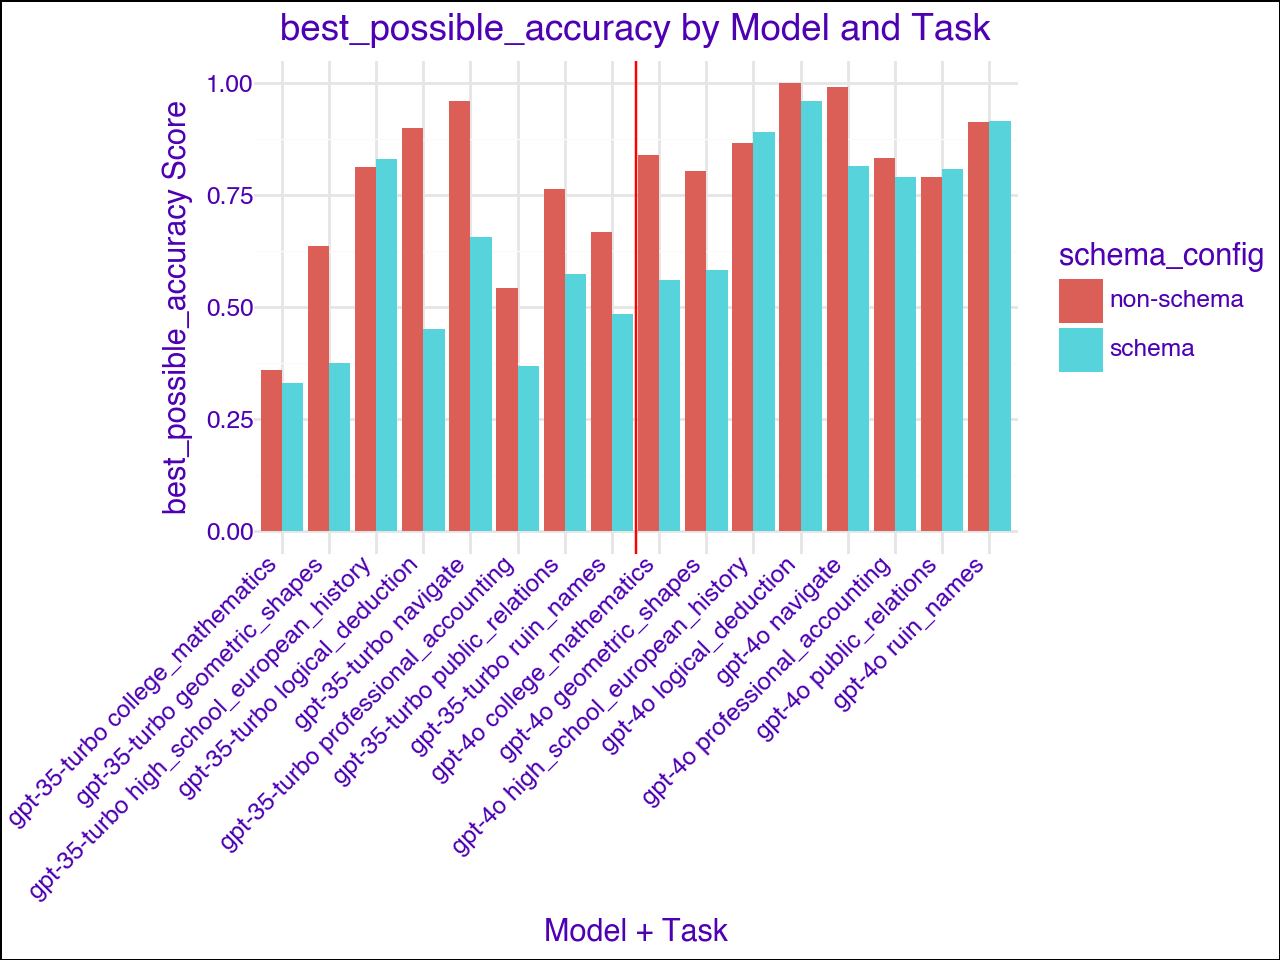

In [20]:
display(plot_metrics(stability_df, 'best_possible_accuracy', color="#4e00b3"))

For GPT-3.5 non-schemas have 7 out of 8 have better best_possible_accuracy scores, with one a tie. GPT-4o looks like 5 are better with some ties. 

How about worst_possible_scores? 

Worst possible accuracy: A maximially skeptical metric that says if any of the runs got the answer wrong then score it wrong. 

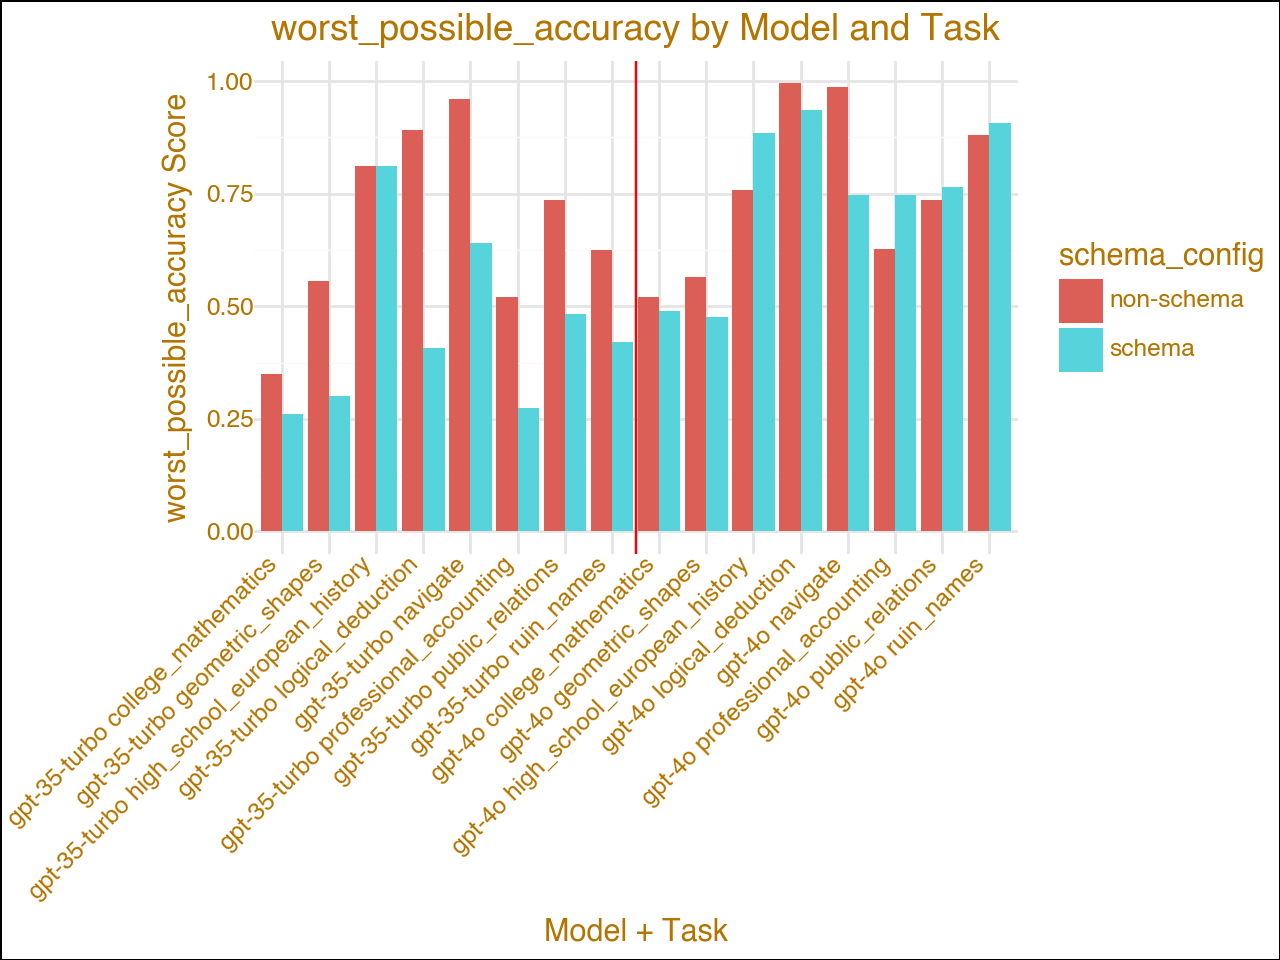

In [ ]:
display(plot_metrics(stability_df, 'worst_possible_accuracy', color="#b37400"))

GPT-3.5 has 7 of 8 tasks performing better with out a schema under worst case conditions and the effect is considerable. GPT-4o has 4 of 8 better without a schema but less of an effect. 

### Observations:

This is a very limited experiment but I'd say some signal was recovered. Schemas improve but do not fix determinism and they tend to reduce accuracy. 

W;AI (Coded with AI assistance)